## Volatility Risk Premium

Prepared by Jirong Huang (jironghuang88@gmail.com)

## Disclaimer

None of the contents constitute an offer to sell, a solicitation to buy, or a recommendation or endorsement for any security or strategy, nor does it constitute an offer to provide investment advisory services
Past performance is no indicator of future performance
Provided for informational purposes only
All investments involve risk, including loss of principal

Note: I have a vested interest in this strategy. Variant of the strategy has been deployed since start of Sep-2020

## Summary 

- Out-of-sample walk forward analysis sharpe ratio is 0.89 and sortino ratio is 1.21
- Strategy exhibits a negative skew of -0.88 and fat tail kurtosis of 8.18.
- Such a strategy has the potential to perform well in volatile environment-evident by the explosive returns during 2020 (~ +100%) and normal environment (> 100% in 2017)
- The strategy exhibits a low correlation of 0.25 to SPY 

## Introduction

In this notebook, I will explore term structure of VIX i.e. VIX and VIX3M as a viable signal for volatility trading.

Data was sourced from couple of sources,

- Expired long VIX futures ETF, VXX and short VIX futures ETF, SVXY from ETF providers adjusted for reverse splits
- Current VXX and SVXY ETFs adjusted for reverse splits
- VIX and VIX3M from yahoo finance and CBOE respectively
- SPY from yahoo finance used for benchmarking

## Approach 

### Signal generation

To generate a signal, I will compare term structure of VIX against VIX3M.

- If VIX < VIX3m, a long position on SVXY is initiated the next day.
- If VIX > VIX3m, a long position on VXX is initiated the next day. 

### Continuous signal 

To smooth out returns stream, I convert VIX/VIX3M into a continuous signal,

- self.data['signal_strength'] = 1 - (self.data['vix'] / self.data['vix3m'])

A normalizing denominator, j (0.1, 0.15, 0.2, 0.25 parameters are tested for optimization) is further applied to convert continuous signal to -100% to 100% signal

- self.data['signal_strength_adj_' + str(i)] = self.data['signal_strength']/j     

The ensuing signal is the proportion of available capital (or fix capital) used in position sizing.


### Walk forward and Block boostrapping analysis

- To pick the best parameter, I performed a walk forward and block boostrapping analysis using a package that I developed (https://pypi.org/project/bootstrapindex/) 
- Walk Forward Analysis optimizes on a training set; test on a period after the set and then rolls it all forward and repeats the process. There are multiple out-of-sample periods and the combined results can be analyzed.
- To facilitate Walk Forward Analysis, the package produces start and end of block bootstrap indexes within each training set data chunk.
- Block bootstrap indexes basically represents continuous chunks of time series indexes that are sampled with replacement within a training set data chunk. 


In [1]:
#!pip install bootstrapindex
import numpy as np
import pandas as pd
import util as ut
import pyfolio
import yfinance as yf
from vrp_research_class import vrp_research
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/home/jirong/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
#Initiate research class
strategy = vrp_research(vix_cap_range = [10, 15, 20, 25],\
                        snp_cap_range = [10, 15, 20, 25],\
                        num_samples_per_period=100,\
                        min_sample_size=100,prop_block_bootstrap=0.10,\
                        days_block=252,starting_index=22  
                        )                 

#Obtain data (csv and from yahoo finance)
strategy.get_data()

[*********************100%***********************]  4 of 4 completed


## Generating signals

- Signals are appended onto a dataframe object.

In [3]:
#Generating signals
strategy.generate_vix_signal()
strategy.generate_snp_signal()

## Generating walk forward and bootstrap indexes

- 8 blocks of in-sample and out-of-sample blocks are generated.
- Expanding window is used for in-sample blocks.
- Within each of the training dataset, I generated 100 samples with proportion 10% of training dataset of minimum sample size 100. The index of dataframe is encapsulated under boostrap_index (start_index and end_index) 

In [4]:
#Generating walk forward training and testing periods with block bootstrap index
strategy.generate_boostrap_periods()
strategy.index

1
2
3
4
5
6
7
8


{1: {'in_sample_index': [22, 273],
  'out_sample_index': [274, 525],
  'bootstrap_index': {'start_index': array([120,  56,  36,  82,  82,  87, 168, 104,  80, 140, 168, 137, 143,
           88,  49,  75, 114, 155,  68,  33,  60,  64,  57,  96, 120, 118,
           73, 144,  50, 162, 160,  25,  41, 168, 157, 162, 106,  45, 129,
           75, 139, 119,  50,  31, 126,  91,  41, 112, 162,  39, 149,  84,
           90,  77,  57,  45, 165,  32, 170,  79, 100, 148, 169, 135, 143,
          128,  40,  41, 141,  31,  52, 104,  40,  93, 153, 137, 116,  86,
           70,  59,  91, 151,  59, 149,  94,  73,  29,  59, 123,  42,  74,
           43, 129, 148, 161, 158, 116,  71, 113, 125]),
   'end_index': array([220, 156, 136, 182, 182, 187, 268, 204, 180, 240, 268, 237, 243,
          188, 149, 175, 214, 255, 168, 133, 160, 164, 157, 196, 220, 218,
          173, 244, 150, 262, 260, 125, 141, 268, 257, 262, 206, 145, 229,
          175, 239, 219, 150, 131, 226, 191, 141, 212, 262, 139, 249, 184,
  

## Average results of in-sample blocks

- 100 samples are generated for each training block
- Performance statistics (sharpe, sortino, max drawdown, annualized returns, annualized returns/ max drawdown) are averaged  across all boostrap samples for each period.

In [5]:
#Generating average stats for in-sample period
stats = strategy.compute_perf_mult_rule_single_period()    
avg_stats = stats.groupby(['period']).mean()
avg_stats

,bootstrap_index,sharpe_term10,sharpe_term15,sharpe_term20,sharpe_term25,sortino_term10,sortino_term15,sortino_term20,sortino_term25,drawdown_term10,...,returns_snp20,returns_snp25,returns_drawdown_snp10,returns_drawdown_snp15,returns_drawdown_snp20,returns_drawdown_snp25,returns_drawdown_term10,returns_drawdown_term15,returns_drawdown_term20,returns_drawdown_term25
period,,,,,,,,,,,,,,,,,,,,,
1.0,49.5,1.986088,1.851814,1.855907,1.904741,3.108666,2.722373,2.682600,2.805131,-27.581813,...,48.933986,37.615076,-8.644620,-7.171488,-6.633201,-6.052065,-9.883501,-7.580260,-7.055534,-6.915615
2.0,49.5,1.508014,1.411400,1.383433,1.384098,2.315411,2.053707,1.975059,1.988159,-22.504278,...,24.920916,19.388703,-4.598757,-4.093960,-3.866136,-3.623697,-6.597622,-5.142253,-4.702421,-4.557108
3.0,49.5,1.336408,1.229096,1.215519,1.220824,1.954733,1.717916,1.677380,1.695261,-20.364384,...,17.549560,13.694375,-3.809018,-3.418851,-3.233760,-3.054200,-5.052174,-3.818569,-3.523917,-3.444665
4.0,49.5,1.149015,1.072939,1.056270,1.058368,1.677955,1.508601,1.465524,1.476285,-21.844738,...,14.085613,11.010063,-3.371062,-3.054303,-2.884526,-2.721475,-4.606838,-3.627331,-3.335582,-3.211559
5.0,49.5,1.038677,1.002491,0.977690,0.971929,1.429526,1.335088,1.285062,1.279630,-26.258573,...,15.446080,12.141840,-3.314534,-3.001406,-2.845435,-2.735075,-3.558793,-2.931234,-2.526284,-2.438593
6.0,49.5,1.103064,1.094936,1.074754,1.063703,1.392645,1.340505,1.295954,1.283666,-27.288955,...,15.645716,12.355233,-2.119386,-1.970163,-1.882687,-1.847775,-3.577280,-3.174279,-2.762335,-2.634287
7.0,49.5,1.074623,1.089975,1.092726,1.087799,1.313407,1.316230,1.305112,1.299148,-27.912654,...,14.060209,11.165491,-1.759417,-1.602191,-1.538217,-1.517314,-2.899672,-2.834264,-2.622420,-2.491202
8.0,49.5,0.883256,0.899585,0.896543,0.886204,1.066891,1.074428,1.060853,1.049671,-28.375484,...,11.265022,8.969970,-1.285961,-1.142266,-1.099724,-1.088611,-2.035517,-2.119423,-2.000030,-1.913029


## Examining in-sample performance statistics

In [7]:
#sharpe_term
sharpe_term = avg_stats[['sharpe_term' + str(i) for i in [10,15,20,25]]]
sharpe_term.columns = [10,15,20,25]
print('sharpe')
sharpe_term

#sortino_term
sortino_term = avg_stats[['sortino_term' + str(i) for i in [10,15,20,25]]]
sortino_term.columns = [10,15,20,25]
print('sortino')
sortino_term

#returns_term
returns_term = avg_stats[['returns_term' + str(i) for i in [10,15,20,25]]]
returns_term.columns = [10,15,20,25]
print('annualized compound returns')
returns_term

#drawdown_term
drawdown_term = avg_stats[['drawdown_term' + str(i) for i in [10,15,20,25]]]
drawdown_term.columns = [10,15,20,25]
print('max drawdown')
drawdown_term

#returns_drawdown_term
returns_drawdown_term = avg_stats[['returns_drawdown_term' + str(i) for i in [10,15,20,25]]]
returns_drawdown_term.columns = [10,15,20,25]
print('annualized compound returns/max drawdown')
returns_drawdown_term

sharpe


,10,15,20,25
period,,,,
1.0,1.986088,1.851814,1.855907,1.904741
2.0,1.508014,1.411400,1.383433,1.384098
3.0,1.336408,1.229096,1.215519,1.220824
4.0,1.149015,1.072939,1.056270,1.058368
5.0,1.038677,1.002491,0.977690,0.971929
6.0,1.103064,1.094936,1.074754,1.063703
7.0,1.074623,1.089975,1.092726,1.087799
8.0,0.883256,0.899585,0.896543,0.886204


sortino


,10,15,20,25
period,,,,
1.0,3.108666,2.722373,2.682600,2.805131
2.0,2.315411,2.053707,1.975059,1.988159
3.0,1.954733,1.717916,1.677380,1.695261
4.0,1.677955,1.508601,1.465524,1.476285
5.0,1.429526,1.335088,1.285062,1.279630
6.0,1.392645,1.340505,1.295954,1.283666
7.0,1.313407,1.316230,1.305112,1.299148
8.0,1.066891,1.074428,1.060853,1.049671


annualized compound returns


,10,15,20,25
period,,,,
1.0,227.566349,163.881467,130.222634,105.307743
2.0,124.244593,90.546997,69.999219,56.062635
3.0,93.620982,65.269233,49.845408,40.211218
4.0,80.624896,56.473604,42.441959,34.099573
5.0,66.252668,51.478994,39.079605,30.940727
6.0,70.361801,59.063902,45.765138,35.691461
7.0,62.909018,55.464117,44.814832,35.376120
8.0,50.133114,44.785491,36.478926,28.929235


max drawdown


,10,15,20,25
period,,,,
1.0,-27.581813,-23.876240,-19.456006,-15.782474
2.0,-22.504278,-19.176203,-15.360840,-12.431417
3.0,-20.364384,-16.923517,-13.348329,-10.787504
4.0,-21.844738,-17.748656,-13.982535,-11.362938
5.0,-26.258573,-21.220790,-17.207571,-14.013333
6.0,-27.288955,-22.367338,-18.388250,-15.086780
7.0,-27.912654,-22.922842,-18.737352,-15.447528
8.0,-28.375484,-23.264441,-19.031534,-15.643863


annualized compound returns/max drawdown


,10,15,20,25
period,,,,
1.0,-9.883501,-7.580260,-7.055534,-6.915615
2.0,-6.597622,-5.142253,-4.702421,-4.557108
3.0,-5.052174,-3.818569,-3.523917,-3.444665
4.0,-4.606838,-3.627331,-3.335582,-3.211559
5.0,-3.558793,-2.931234,-2.526284,-2.438593
6.0,-3.577280,-3.174279,-2.762335,-2.634287
7.0,-2.899672,-2.834264,-2.622420,-2.491202
8.0,-2.035517,-2.119423,-2.000030,-1.913029


## Picking best parameter for out-of-sample

- For each period, I find the mode of the parameters under performance statistics sharpe, sortino and annualized returns/max drawdown
- In the analysis below, you will notice that parameter j=10 is picked for first 7 periods and j=8 is picked for the last period.

In [8]:
#obtain best index across sharpe, sortino and returns/drawdown
param = pd.concat([sharpe_term.idxmax(axis="columns"),
                   sortino_term.idxmax(axis="columns"),
                   abs(returns_drawdown_term).idxmax(axis="columns")], axis = 1)

param.columns = ['sharpe','sortino','returns_drawdown']
param
opt_param = list(np.round(np.array(param.mode(axis=1).iloc[:,0])).astype(int))
opt_param

,sharpe,sortino,returns_drawdown
period,,,
1.0,10,10,10
2.0,10,10,10
3.0,10,10,10
4.0,10,10,10
5.0,10,10,10
6.0,10,10,10
7.0,20,15,10
8.0,15,15,15


[10, 10, 10, 10, 10, 10, 10, 15]

## Walk forward out-of-sample results

,period,param,sharpe,sortino,drawdown,returns,returns_drawdown
0,1.0,10.0,1.061625,1.297399,-29.297700,41.158311,-1.404831
1,2.0,10.0,0.474284,0.565753,-27.144884,11.099366,-0.408893
2,3.0,10.0,0.905871,1.194997,-39.834575,38.285318,-0.961108
3,4.0,10.0,0.512280,0.554812,-40.285172,13.120564,-0.325692
4,5.0,10.0,1.992631,1.956419,-27.269010,119.319031,-4.375628
5,6.0,10.0,-0.054977,-0.061145,-30.064195,-7.101617,0.236215
6,7.0,10.0,-0.405757,-0.452111,-25.759100,-10.183997,0.395355
7,8.0,15.0,2.002794,3.588665,-13.273126,95.739200,-7.213011


Sharpe


0.8859879155413738

Sortino


1.013448362764225

Max drawdown


-41.89719348042699

Annualized returns


32.11300175581633

Annualized returns/Drawdown


-0.7664714289471078

Equity curve


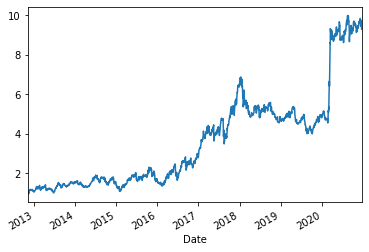

In [9]:
#Walk forward stats
walk_forward_returns_term, perf_stats_term = strategy.walk_forward_compilation('term', opt_param)

perf_stats_term

print('Sharpe')
ut.get_sharpe(walk_forward_returns_term['returns'])
print('Sortino')
ut.get_sortino(walk_forward_returns_term['returns'])
print('Max drawdown')
ut.get_max_drawdown(walk_forward_returns_term['returns'])
print('Annualized returns')
ut.get_compound_returns(walk_forward_returns_term['returns'])
print('Annualized returns/Drawdown')
ut.get_compound_returns(walk_forward_returns_term['returns'])/ut.get_max_drawdown(walk_forward_returns_term['returns'])
print('Equity curve')
(1+walk_forward_returns_term['returns']).cumprod().plot()

## Examining equity curve using fix capital

For a fat-tail strategy of kurtos > 8, it may be advisable to use a fix capital instead to diversify strategy across time.

In the example below, I used a fix constant capital of $10,000

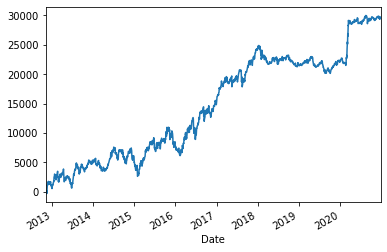

In [10]:
#Using constant capital of $10k
walk_forward_returns_term['profits'] = (walk_forward_returns_term['returns'] * 10000)
cumsum_eqcurve = (walk_forward_returns_term['profits']).cumsum()
cumsum_eqcurve.plot()

In [11]:
walk_forward_returns_term['profits'].groupby(pd.Grouper(freq="Y")).sum()
print(walk_forward_returns_term['profits'].groupby(pd.Grouper(freq="M")).sum().to_string())
print((walk_forward_returns_term['profits'].groupby(pd.Grouper(freq="M")).sum()/10000).to_string())

Date
2012-12-31     526.823123
2013-12-31    4541.244745
2014-12-31    -101.265474
2015-12-31    2959.427613
2016-12-31    6871.883023
2017-12-31    9309.389184
2018-12-31   -2419.857045
2019-12-31     487.976310
2020-12-31    7522.167501
Freq: A-DEC, Name: profits, dtype: float64

Date
2012-11-30    1560.196875
2012-12-31   -1033.373752
2013-01-31    1729.540533
2013-02-28    -559.365879
2013-03-31    1232.023940
2013-04-30    -637.246196
2013-05-31    -191.675035
2013-06-30    -890.593902
2013-07-31    2985.908610
2013-08-31   -1198.475337
2013-09-30    1140.793325
2013-10-31    -181.059103
2013-11-30    1204.613245
2013-12-31     -93.219456
2014-01-31    -598.221566
2014-02-28     127.831562
2014-03-31    -708.650915
2014-04-30      37.229704
2014-05-31    1685.238470
2014-06-30    1479.651127
2014-07-31   -1382.211981
2014-08-31    1174.320619
2014-09-30   -1241.520018
2014-10-31     422.880779
2014-11-30     969.527052
2014-12-31   -2067.340307
2015-01-31   -2358.695692
2015-02-28    2328.912120
2015-03-31     616.111599
2015-04-30    1453.047680
2015-05-31    1249.983393
2015-06-30    -844.595503
2015-07-31     704.831872
2015-08-31     465.288330
2015-09-30    -305.204113
2015-10-31    2173.730566
2015-11-30    -533.127609
2015-12-31   -1990.855028
2016-01

In [ ]:
#Compute win rate (year, month, daily) and distribution of winning-losing trades

## Generating performance statistics using pyfolio and using SPY as benchmark

- The sharpe ratio for the strategy is 0.89 and sortino ratio is 1.21
- Strategy exhibits a negative skew of -0.88 and fat tail kurtosis of 8.18.
- Such a strategy has the potential to perform well in volatile environment - evident by the explosive returns during 2020 (~ +100%) and normal environment (> 100% in 2017)
- The strategy exhibits a low correlation of 0.25 to SPY 

In [12]:
#Get correlation with market
prices_df = yf.download('SPY', start = '2005-01-01', end = '2020-12-31', adjusted = True)
prices_df['date'] = prices_df.index
prices_df=prices_df[['date','Adj Close']]
prices_df['spy_returns']= prices_df['Adj Close'].pct_change()
strategy_returns = walk_forward_returns_term['returns']                        
vix_equity = pd.merge(strategy_returns, prices_df, left_on='Date', right_on='date')
vix_equity.index=vix_equity['date']
vix_equity.index.tz_localize('US/Eastern')
vix_equity

[*********************100%***********************]  1 of 1 completed


/home/jirong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


DatetimeIndex(['2012-11-05 00:00:00-05:00', '2012-11-06 00:00:00-05:00',
               '2012-11-07 00:00:00-05:00', '2012-11-08 00:00:00-05:00',
               '2012-11-09 00:00:00-05:00', '2012-11-12 00:00:00-05:00',
               '2012-11-13 00:00:00-05:00', '2012-11-14 00:00:00-05:00',
               '2012-11-15 00:00:00-05:00', '2012-11-16 00:00:00-05:00',
               ...
               '2020-12-14 00:00:00-05:00', '2020-12-15 00:00:00-05:00',
               '2020-12-16 00:00:00-05:00', '2020-12-17 00:00:00-05:00',
               '2020-12-18 00:00:00-05:00', '2020-12-21 00:00:00-05:00',
               '2020-12-22 00:00:00-05:00', '2020-12-23 00:00:00-05:00',
               '2020-12-24 00:00:00-05:00', '2020-12-28 00:00:00-05:00'],
              dtype='datetime64[ns, US/Eastern]', name='date', length=2051, freq=None)

,returns,date,Adj Close,spy_returns
date,,,,
2012-11-05,-0.009982,2012-11-05,120.464371,0.002048
2012-11-06,0.010034,2012-11-06,121.407043,0.007825
2012-11-07,-0.028794,2012-11-07,118.655518,-0.022664
2012-11-08,-0.003127,2012-11-08,117.228783,-0.012024
2012-11-09,0.000436,2012-11-09,117.330688,0.000869
2012-11-12,0.046955,2012-11-12,117.424118,0.000796
2012-11-13,-0.002122,2012-11-13,117.016457,-0.003472
2012-11-14,-0.033875,2012-11-14,115.436867,-0.013499
2012-11-15,-0.010647,2012-11-15,115.241562,-0.001692


Start date,2012-11-05
End date,2020-12-28
Total months,97
,Backtest
Annual return,32.1%
Cumulative returns,864.6%
Annual volatility,41.2%
Sharpe ratio,0.89
Calmar ratio,0.75
Stability,0.90
Max drawdown,-43.0%


/home/jirong/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,43.03,2014-07-03,2015-01-30,2015-06-11,246
1,41.90,2018-01-11,2019-10-08,2020-03-12,566
2,41.50,2015-10-19,2016-02-12,2016-05-27,160
3,33.40,2016-06-06,2016-06-28,2016-08-05,45
4,29.30,2013-04-12,2013-06-24,2013-07-31,79


Stress Events,mean,min,max
Apr14,0.02%,-4.08%,2.70%
Oct14,0.18%,-8.08%,6.66%
Fall2015,0.05%,-6.38%,8.81%
Recovery,0.14%,-4.38%,8.57%
New Normal,0.14%,-18.26%,18.53%


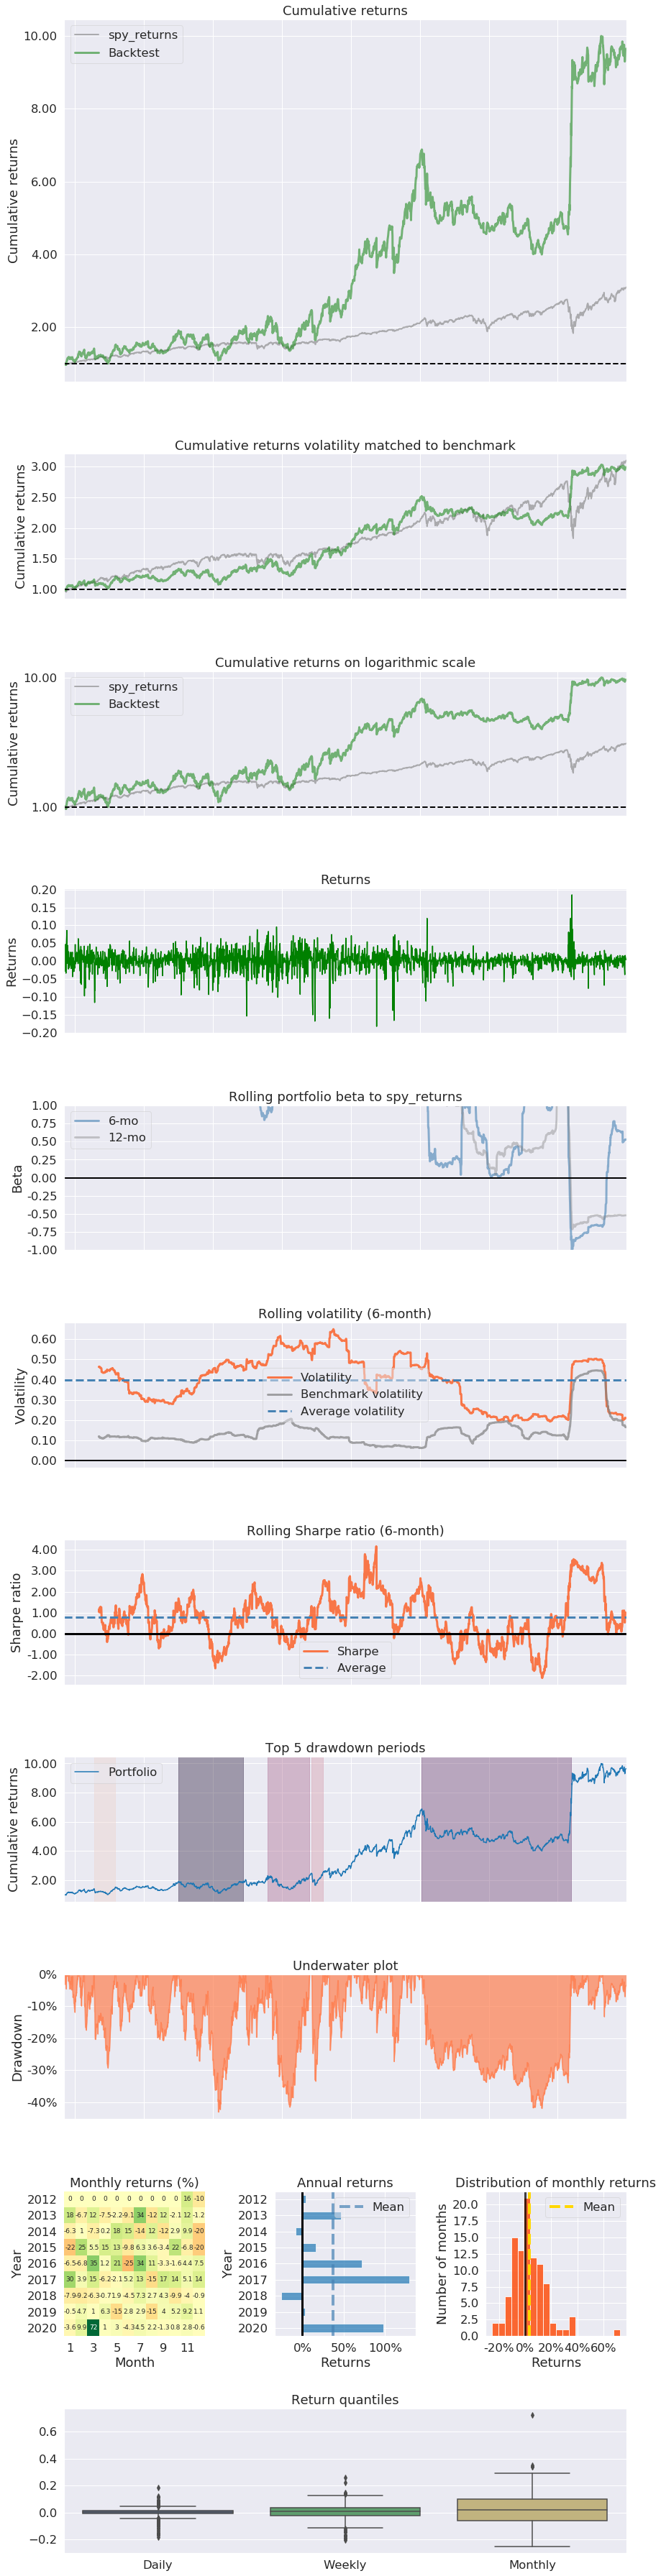

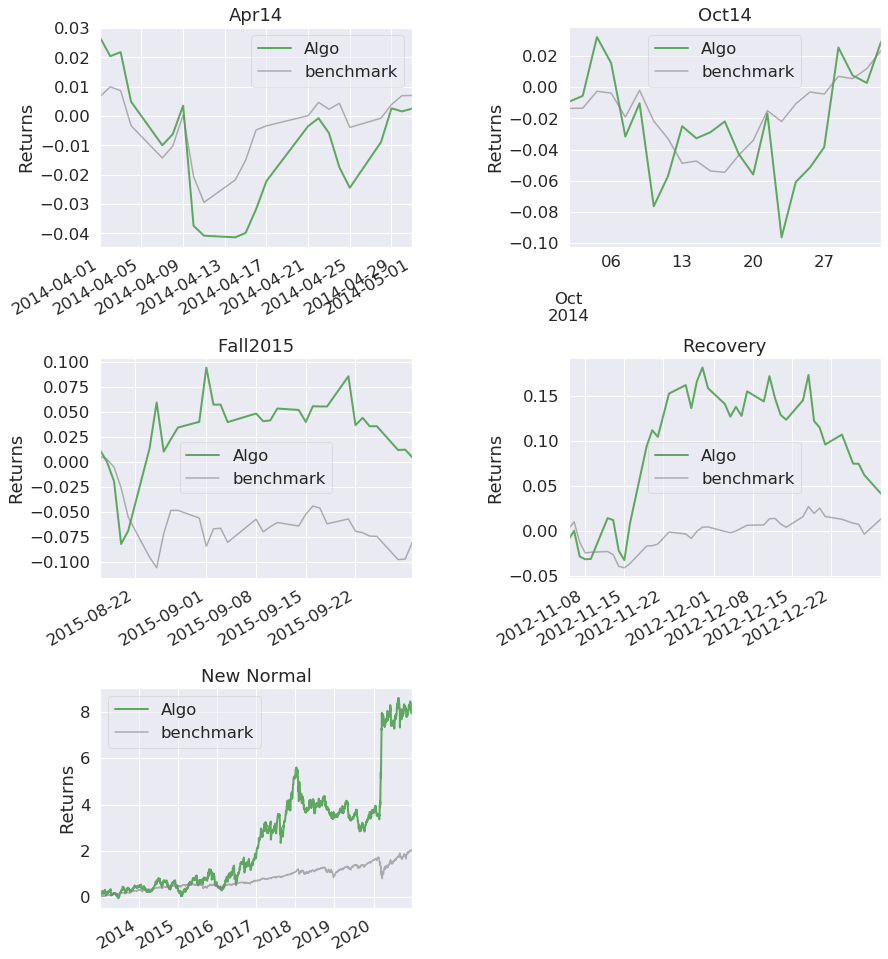

In [13]:
pyfolio.create_full_tear_sheet(vix_equity['returns'], benchmark_rets=vix_equity['spy_returns']) 

In [14]:
#Correlation of SPY and VRP returns
vix_equity[['returns', 'spy_returns']].corr()

,returns,spy_returns
returns,1.000000,0.251063
spy_returns,0.251063,1.000000


### Future developments

- I may incorporate term structure of VIX further out such as VIX6M and VIX9M. A regression slope could be used instead for the continuous signal used in position sizing.
